In [9]:
# 特征向量化——稀疏表示
from sklearn.feature_extraction.text import CountVectorizer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
"""
CountVectorizer是属于常见的特征数值计算类，
是一个文本特征提取方法。对于每一个训练文本，
它只考虑每种词汇在该训练文本中出现的频率。
"""
vectorizer = CountVectorizer()
corpus = [
    "This is the first document.",
    "This is the second document.",
    "And the third one",
    "Is this the first document?",
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
"""
CountVectorizer会将文本中的词语转换为词频矩阵，
它通过fit_transform函数计算各个词语出现的次数
"""
X = vectorizer.fit_transform(corpus)
# 上面代码等价于下面两行代码
# X = vectorizer.fit(corpus)
# X_fit = X.transform(corpous)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
# 所有文本的词汇；列表型
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# 词汇表；字典型
vectorizer.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
vectorizer

"""
    and document first is one second the third this
1    0      1      1    1  0    0     1    0     1
2    0      1      0    1  0    1     1    0     1
3    1      0      0    0  1    0     1    1     0
4    0      1      1    1  0    0     1    0     1
"""



'\n    and document first is one second the third this\n1    0      1      1    1  0    0     1    0     1\n2    0      1      0    1  0    1     1    0     1\n3    1      0      0    0  1    0     1    1     0\n4    0      1      1    1  0    0     1    0     1\n'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# 将结果转化为稀疏矩阵矩阵的表示方式
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# 每个词在所有文档中的词频
X.toarray().sum(axis=0)

array([1, 3, 2, 3, 1, 1, 4, 1, 3], dtype=int64)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 利用语料库训练word2vec

In [4]:
import jieba
import multiprocessing
from gensim.models.word2vec import Word2Vec

In [5]:
with open("./in_the_name_of_people.txt", "r", encoding="utf-8") as f:
    content = f.readlines()
vocab = []
# 分词
for line in content:
    seg = jieba.lcut(line)
    vocab.append(seg)
cpu_count = multiprocessing.cpu_count()
vocab_dim = 100  # 词向量对应的维度
n_iterations = 1  # 迭代次数
n_exposures = 10  # 所有频数超过10的词语
window_size = 7

model = Word2Vec(
    vector_size=vocab_dim,
    min_count=n_exposures,
    window=window_size,
    workers=cpu_count,
    epochs=n_iterations,
)
model.build_vocab(vocab)  # input: list
model.train(vocab, total_examples=model.corpus_count, epochs=model.epochs)
model.save("./w2v.pkl")

In [6]:
model.wv.most_similar("名义")

[('然后', 0.8560000061988831),
 ('月', 0.8505196571350098),
 ('紧急', 0.8493430614471436),
 ('家里', 0.8481209874153137),
 ('乱', 0.8480457067489624),
 ('保姆', 0.8471118807792664),
 ('批', 0.8465307950973511),
 ('联系', 0.8449636101722717),
 ('据', 0.8440296053886414),
 ('时代', 0.8439958095550537)]

## 得到句子的特征

In [23]:
import numpy as np
import jieba


# 直接词向量相加求平均
def fea_sentence(list_w):
    # vovab_dim=100
    n0 = np.array([0.0 for i in range(vocab_dim)], dtype=np.float32)
    for i in list_w:
        n0 += i
    fe = n0 / len(list_w)
    fe = fe.tolist()  # 将数组或矩阵转换为list
    return fe


def parse(data, w2v_model):
    xVec = []
    for x in data:
        sentence = []
        for word in x:
            if word in w2v_model.wv.index_to_key:
                sentence.append(w2v_model.wv[word])
            else:  # 词不存在，则补零向量。
                sentence.append([0.0 for i in range(vocab_dim)])
        xVec.append(fea_sentence(sentence))

    xVec = np.array(xVec)

    return xVec


if __name__ == "__main__":
    texts = [
        "如果是英文的话，除了前面的分词不一样，其余部分也是同样的步骤。",
        "其中vocab_dim为词向量对应的维度，一般选100-200之间。",
        "到现在呢，我们已经能够提取每个词的特征了，但是我们的任务是针对句子进行分类或者回归，对象是句子而非词语，所以我们需要进一步得到句子的特征。",
        "我们用到的是求平均的方法，即通过将句子中出现的词的词向量的相加之后，再除以词的数量，得到句子的特征.",
    ]

    data = []

    for sentence in texts:
        seg = jieba.lcut(sentence)
        data.append(seg)

    print("加载word2vec模型")
    model = Word2Vec.load("./w2v.pkl")
    xVec = parse(data, model)

加载word2vec模型


In [24]:
xVec[0]

array([-0.14090908,  0.44309968, -0.26256034, -0.1414606 ,  0.00168851,
       -0.53879899,  0.2219162 ,  0.77458358, -0.19273089, -0.37900487,
        0.01191619, -0.54829729, -0.0742288 ,  0.2490855 ,  0.2307677 ,
        0.04032084,  0.2596322 , -0.11123938, -0.30615085, -0.86492586,
        0.14301251,  0.23710409,  0.31991014, -0.53142279, -0.13322172,
       -0.02606489, -0.33039448, -0.19228971, -0.56441158,  0.18875434,
        0.6804474 , -0.201508  , -0.08792181, -0.38213283,  0.04958905,
        0.75640154, -0.10022117, -0.16222551, -0.0064445 , -0.44907534,
        0.01212004, -0.38890877, -0.46100256, -0.23154628,  0.53708279,
       -0.04109504, -0.2713654 , -0.0439161 ,  0.37907359, -0.02899378,
        0.06989395, -0.28961939, -0.23576194,  0.18840401, -0.28764939,
        0.12463727,  0.30622026, -0.266817  , -0.35738903,  0.14355381,
        0.01145166,  0.01848275,  0.14017625, -0.11030918, -0.61644983,
        0.33361986,  0.22206733,  0.36571068, -0.3956379 ,  0.51

In [25]:
xVec[1]

array([-0.06542743,  0.20231032, -0.11993395, -0.06453809, -0.0004288 ,
       -0.24548276,  0.10094556,  0.35428584, -0.08773282, -0.17263   ,
        0.00577208, -0.24965174, -0.03379507,  0.11391798,  0.10594446,
        0.01792781,  0.1188386 , -0.05153703, -0.14095597, -0.39376867,
        0.0662796 ,  0.10699806,  0.14707163, -0.24208313, -0.06056881,
       -0.01254947, -0.14999324, -0.0875607 , -0.25732929,  0.0867468 ,
        0.30934754, -0.09149221, -0.04118649, -0.17579606,  0.02412056,
        0.34568924, -0.04626603, -0.07356893, -0.00349467, -0.20514758,
        0.00428017, -0.17767316, -0.20845309, -0.10530151,  0.24605602,
       -0.01897866, -0.12384298, -0.02016452,  0.17307353, -0.01358672,
        0.03209355, -0.13210699, -0.10793121,  0.08466174, -0.13300039,
        0.05784871,  0.14114295, -0.11993627, -0.16270773,  0.06428818,
        0.00559851,  0.00825547,  0.06321663, -0.05051802, -0.28050637,
        0.15178943,  0.10246655,  0.16801819, -0.18077081,  0.23

In [56]:
for word in model.wv.index_to_key:
    print(word,model.wv[word])

， [-0.3242792   1.0212015  -0.5986267  -0.32370362 -0.00886697 -1.2404113
  0.5170505   1.7829591  -0.44188595 -0.8725083   0.03338768 -1.2609986
 -0.172785    0.5702323   0.52523714  0.09019012  0.5959765  -0.2564467
 -0.70991594 -1.988459    0.32991233  0.5475122   0.7384494  -1.2188183
 -0.30685708 -0.06347314 -0.7577834  -0.4432522  -1.298274    0.42924663
  1.549114   -0.46212977 -0.1940259  -0.8843678   0.11451481  1.7345862
 -0.2316009  -0.37966824 -0.01376375 -1.0408769   0.01711554 -0.8890556
 -1.0604837  -0.5375874   1.2332333  -0.09847288 -0.6316699  -0.09478879
  0.8722351  -0.06187003  0.15326537 -0.6583671  -0.5398455   0.43444514
 -0.656285    0.27899322  0.71034646 -0.62086576 -0.8241367   0.33908942
  0.02392065  0.03555132  0.31584367 -0.25730386 -1.4131175   0.765756
  0.50994253  0.83918595 -0.9079527   1.1878037  -0.7794953   0.33596754
  1.0187413   0.18345009  1.0127542  -0.10450187  0.21724424 -0.2919696
 -0.15514296 -0.3482643  -0.8074189  -0.26815128 -0.766874

田 [-0.04827787  0.12804921 -0.09087042 -0.0466728   0.00808551 -0.16378169
  0.06395211  0.24585067 -0.050427   -0.12168156 -0.00047585 -0.17241536
 -0.0186267   0.06827231  0.07134316  0.01048739  0.07235576 -0.03763926
 -0.08840432 -0.27337804  0.04189274  0.08117265  0.09909766 -0.16300361
 -0.04261525 -0.00978925 -0.10605311 -0.06258713 -0.17208892  0.06186277
  0.22105892 -0.06068048 -0.03707409 -0.11450247  0.02517867  0.22559349
 -0.0332986  -0.04666685 -0.01140652 -0.13126968  0.00564389 -0.11956058
 -0.13774297 -0.06772385  0.16990198 -0.00899109 -0.08158859 -0.0052636
  0.11653717 -0.00295454  0.03149329 -0.097521   -0.07263268  0.05022974
 -0.08164175  0.04262511  0.08955972 -0.07650107 -0.11512692  0.04289015
  0.01116142  0.0058847   0.05246403 -0.03222063 -0.20067194  0.09675371
  0.0777018   0.11952523 -0.13210319  0.16149579 -0.11038241  0.03548324
  0.1388209   0.0223334   0.13482903 -0.01075223  0.03761618 -0.0394452
 -0.01458876 -0.04803213 -0.10495361 -0.03912898 -0

一只 [-0.02330917  0.04495869 -0.03155851 -0.0184693   0.00420907 -0.07551109
  0.01775881  0.09986174 -0.0271672  -0.03707651 -0.00598995 -0.0596045
 -0.01191562  0.04038142  0.0245584   0.0069187   0.02347359 -0.00421187
 -0.03293455 -0.10247276  0.01928355  0.0222399   0.04288599 -0.0729016
 -0.01293825 -0.00651296 -0.03546277 -0.01641531 -0.07727862  0.0326804
  0.07898547 -0.01734925 -0.00609716 -0.04823559  0.00942198  0.09938975
 -0.01473481 -0.02729544  0.00380558 -0.05865376  0.00392085 -0.03935025
 -0.04651728 -0.0374207   0.0586812  -0.00542624 -0.04013357 -0.0112639
  0.03931322 -0.01328238  0.00910392 -0.0261471  -0.0301334   0.02000908
 -0.04461749  0.01917623  0.03444423 -0.04055348 -0.03791142  0.01611802
  0.01192842 -0.00261589  0.01879931 -0.02186005 -0.07872824  0.04281036
  0.0173792   0.0457863  -0.04281504  0.05619399 -0.03692827  0.01301814
  0.0527559   0.01861585  0.06342555 -0.00211069  0.01573091 -0.02109128
 -0.01101922 -0.02690617 -0.05146402 -0.00686538 -0.

进入 [-0.010303    0.04672456 -0.02225587 -0.01642636 -0.00056023 -0.04197979
  0.02328096  0.06626791 -0.02650611 -0.03084376  0.00170969 -0.05494607
 -0.00839426  0.01662907  0.01461267  0.00073259  0.01766152 -0.00334529
 -0.02001029 -0.07270249  0.01531361  0.02966298  0.03577112 -0.04409974
 -0.01661258 -0.0010562  -0.03016709 -0.01424505 -0.05150333  0.01564808
  0.07120053 -0.02218768 -0.00312876 -0.04060705 -0.00144012  0.06328451
 -0.01680042 -0.00992184  0.00795172 -0.04532727  0.00668048 -0.04296802
 -0.03809129 -0.02193773  0.05218807  0.00447242 -0.0206884  -0.00660887
  0.04175007 -0.0013075   0.00678058 -0.02827822 -0.02489705  0.0215185
 -0.03416583  0.01569648  0.03708276 -0.01642398 -0.02404443  0.01753146
 -0.00218531  0.00570576  0.02109874 -0.0067532  -0.04879734  0.03724286
  0.01297431  0.02374077 -0.04461766  0.04008887 -0.0335103   0.00974862
  0.04646227  0.00797538  0.04304729 -0.01011658 -0.00128653 -0.01608163
 -0.01320067 -0.00746722 -0.0230632  -0.01180874 

调研 [-0.01636047  0.05541477 -0.03009978 -0.01375058  0.00746458 -0.07717699
  0.02717168  0.10162765 -0.0207949  -0.04551379  0.00634343 -0.08028633
 -0.01628537  0.03028204  0.03206269  0.00274265  0.02863583 -0.01496956
 -0.03681851 -0.11494771  0.01660724  0.02627949  0.04662603 -0.06828495
 -0.02353271  0.00384718 -0.04734911 -0.02383163 -0.07642552  0.02533973
  0.0948581  -0.02991875 -0.00840665 -0.04331611  0.00665821  0.09162465
 -0.00414566 -0.0276906   0.00447621 -0.06379757 -0.00629778 -0.05883269
 -0.07096387 -0.02581578  0.07742527 -0.01109287 -0.03750935 -0.0058616
  0.04640165  0.00424509  0.01148461 -0.04532377 -0.03833403  0.03354219
 -0.03915518  0.02405769  0.03398035 -0.04247376 -0.04651698  0.02530349
  0.00580145  0.00577588  0.01930053 -0.01009689 -0.07380893  0.04258062
  0.03415003  0.04889781 -0.05035139  0.07676981 -0.0438756   0.02860899
  0.05893613  0.01107679  0.04974156 -0.00816274  0.01738607 -0.02165199
 -0.01765794 -0.01214394 -0.05528602 -0.0243714  

休息 [-0.01922879  0.02684019 -0.02185062 -0.00473533  0.00842895 -0.04535343
  0.00580302  0.05204531 -0.01006465 -0.02834382 -0.00736546 -0.03765341
 -0.01410185  0.02417833  0.02431842  0.00632094  0.01275342  0.00082237
 -0.02331422 -0.06664868  0.00867638  0.01861942  0.03025536 -0.02814749
 -0.00011447  0.00671378 -0.01924911 -0.02292476 -0.02862351  0.01087942
  0.0481122  -0.00570531  0.00229113 -0.01676449  0.00513246  0.05337428
 -0.01312823 -0.01550034 -0.00420838 -0.02634605  0.00861795 -0.02754414
 -0.03272008 -0.01506346  0.04213409  0.00301771 -0.01577081 -0.01088688
  0.02528211 -0.00047032  0.00936707 -0.02412886 -0.02482333  0.01278096
 -0.02121847  0.01226738  0.02613301 -0.01860206 -0.02424521  0.01312198
 -0.00677526 -0.00360468  0.01433104 -0.01128682 -0.04710152  0.03028692
  0.00769352  0.02133743 -0.03418385  0.04126972 -0.03030405  0.01869803
  0.02295269 -0.001768    0.03876451 -0.0072269  -0.0008165  -0.00618411
  0.00421733 -0.00206528 -0.02687382 -0.00087766

In [73]:
from builtins import bytes, range
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.manifold import TSNE
import gensim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


def tsne_plot(model, words_num):
    labels = []
    tokens = []
    # model.wv.index_to_key是一个列表,里面是分词的结果
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word]) # model.wv[word] 是该word的词向量
        labels.append(word)

    tsne_model = TSNE(
        perplexity=30, n_components=2, init="pca", n_iter=1000, random_state=23
    )
    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(10, 10))
    for i in range(words_num):
        plt.scatter(x[i], y[i])
        if b"\xe0" in bytes(labels[i], encoding="utf-8"):
            this_font = font
        else:
            this_font = "simHei"
        plt.annotate(
            labels[i],
            #                 FontProperties=this_font,
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords="offset points",
            ha="right",
            va="bottom",
        )
        plt.show()

There are 1669 words in vocab
please input how many words you want to plot:10


D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


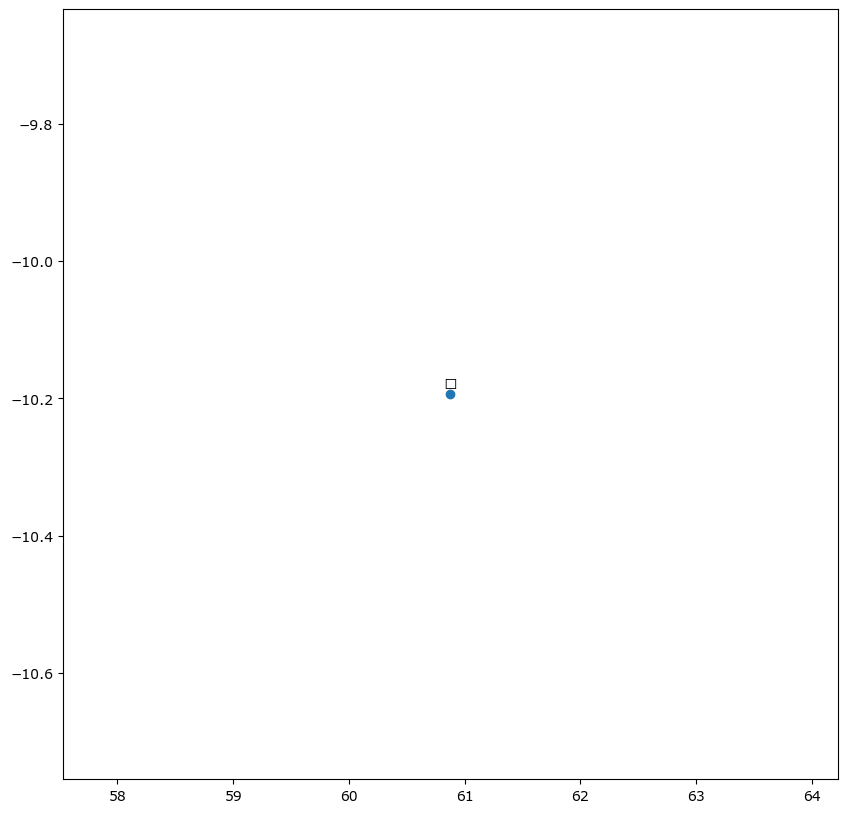

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


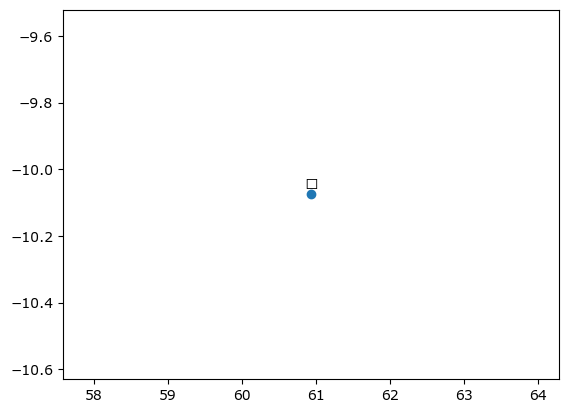

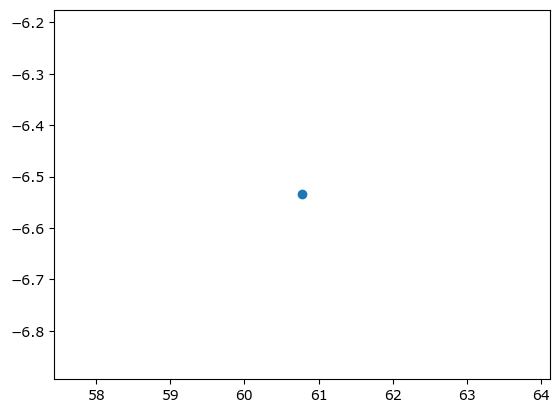

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


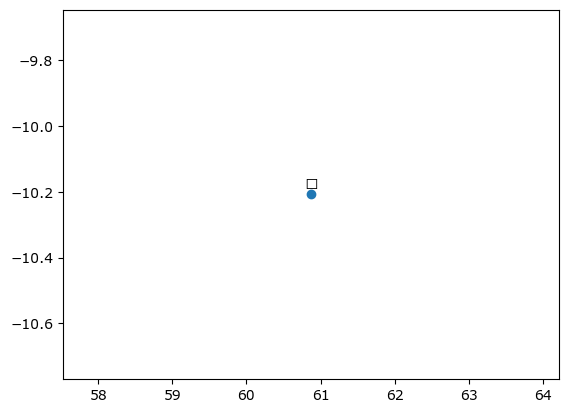

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20102 (\N{CJK UNIFIED IDEOGRAPH-4E86}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


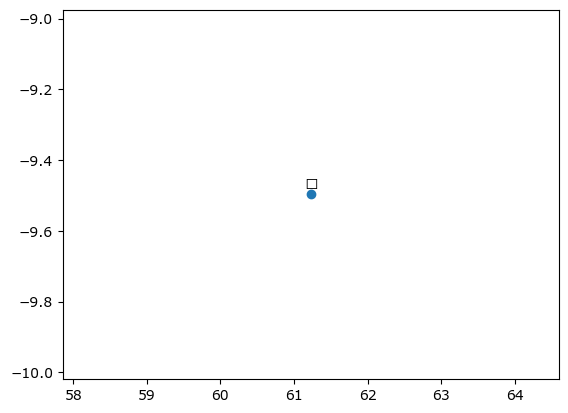

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65281 (\N{FULLWIDTH EXCLAMATION MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


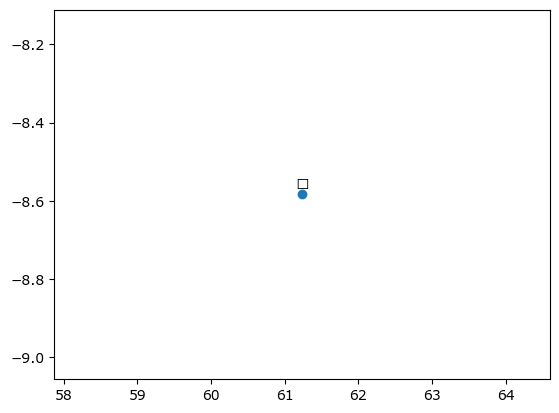

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


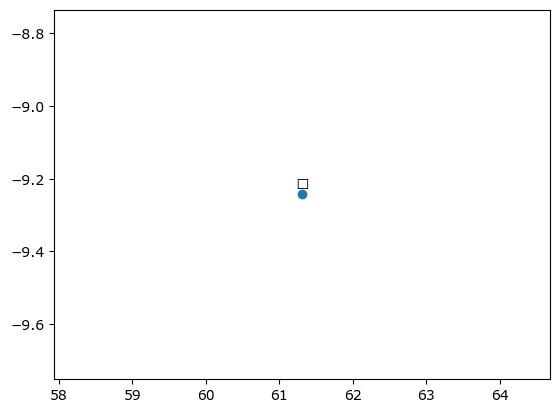

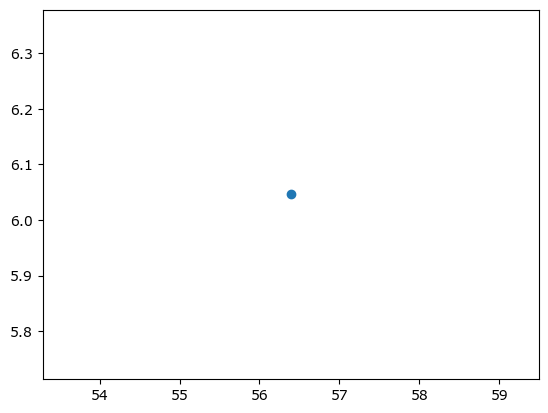

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65311 (\N{FULLWIDTH QUESTION MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


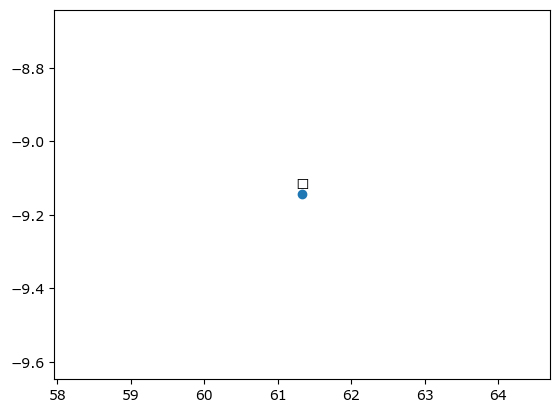

D:\dev\Anaconda3\envs\design39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


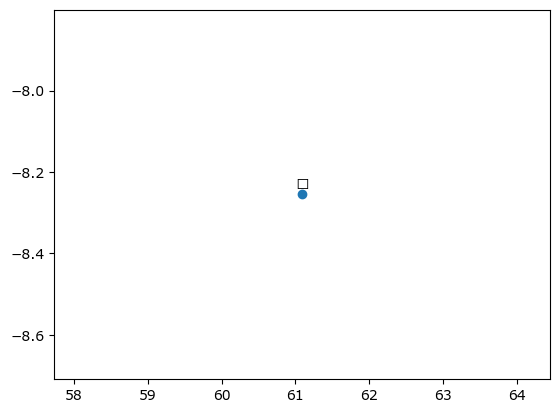

In [74]:
if __name__ == "__main__":
    model = gensim.models.Word2Vec.load("./w2v.pkl")
    print(f"There are {len(model.wv.index_to_key)} words in vocab")
    word_num = int(input("please input how many words you want to plot:"))
    tsne_plot(model, word_num)

In [66]:
labels = []
tokens = []
# model.wv.index_to_key是一个列表,里面是分词的结果
for word in model.wv.index_to_key:
    tokens.append(model.wv[word]) # model.wv[word] 是该word的词向量
    labels.append(word)

tsne_model = TSNE(
    perplexity=30, n_components=2, init="pca", n_iter=1000, random_state=23
)
tokens = np.array(tokens)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for i in new_values:
    x

60.876328 done
60.934547 done
60.775124 done
60.86907 done
61.226894 done
61.235527 done
61.309177 done
56.38928 done
61.328785 done
61.08852 done
61.3219 done
60.164078 done
59.548584 done
61.33573 done
60.199368 done
59.56723 done
60.437794 done
60.798573 done
57.697086 done
58.986794 done
58.922123 done
61.071938 done
59.745384 done
59.19208 done
61.321598 done
60.403168 done
60.769592 done
59.81105 done
57.968914 done
60.889454 done
60.721565 done
61.06829 done
56.47148 done
59.584305 done
55.709858 done
60.270367 done
60.15974 done
59.710007 done
60.36876 done
59.65443 done
59.54734 done
57.003586 done
60.25221 done
57.565006 done
60.516136 done
59.308643 done
59.71027 done
56.84353 done
59.98676 done
58.53519 done
60.22208 done
58.5944 done
59.15595 done
59.058834 done
58.313675 done
58.58054 done
59.61425 done
58.81259 done
56.07529 done
57.76803 done
55.741634 done
57.020306 done
58.74155 done
58.54509 done
58.93805 done
60.42758 done
57.382805 done
57.246986 done
58.285385 don

In [70]:
for i in range(20):
    print(i,"done")

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
